In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from utils import DotDict
import yaml

# Load the map definition from file
filepath = '../../../moro_simulator' + '/world/maze_map.yaml'
with open(filepath) as f:
    msg = DotDict(yaml.safe_load(f))

<IPython.core.display.Javascript object>


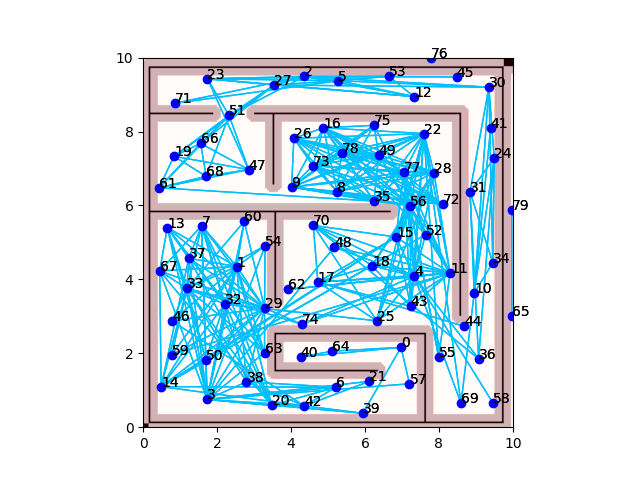

In [37]:
%matplotlib notebook

from probabilistic_roadmap import ProbabilisticRoadmap
import matplotlib.pyplot as plt

import numpy as np

# Set random seed to compare different parameters
np.random.seed(45)

prm = ProbabilisticRoadmap(msg)
prm.plot()

for node, coord in enumerate(prm.nodes):
    plt.text(coord[0], coord[1], str(node))

plt.show()

In [38]:
from shortest_path import dynamic_programming, dijkstra

In [39]:
path = dynamic_programming(prm.graph, 40, 12)
path

array([40,  0, 39, 42, 38, 29, 74,  4, 36, 24, 30,  5, 12])

<IPython.core.display.Javascript object>


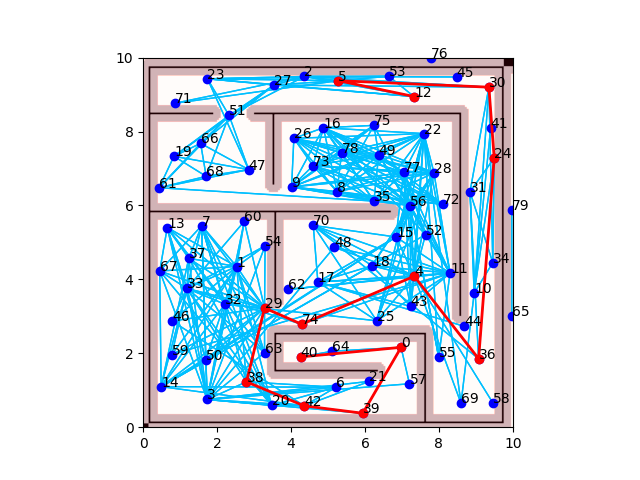

In [40]:
plt.figure()
prm.plot(path)
plt.show()

In [41]:
path = dijkstra(prm.graph, 40, 12)
path

[40, 0, 39, 42, 38, 29, 74, 4, 36, 24, 30, 5, 12]

<IPython.core.display.Javascript object>


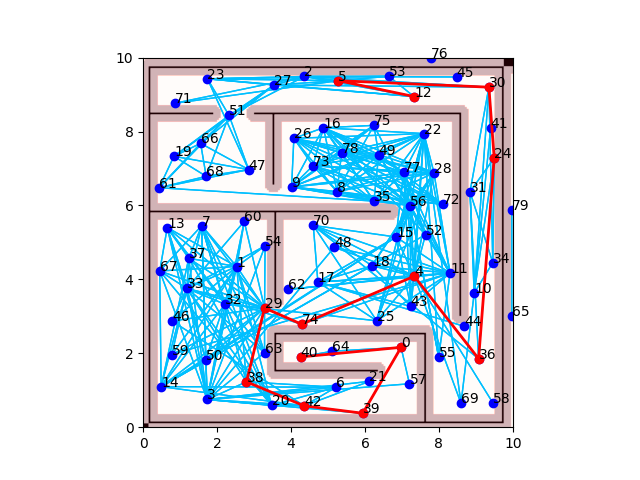

In [42]:
plt.figure()
prm.plot(path)
plt.show()